WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6820830579422782

Generation 2 - Current best internal CV score: 0.6950681396153969

Generation 3 - Current best internal CV score: 0.6951654444549357

Generation 4 - Current best internal CV score: 0.6951654444549357

Generation 5 - Current best internal CV score: 0.695444245113776

Best pipeline: KNeighborsClassifier(GradientBoostingClassifier(RobustScaler(input_matrix), learning_rate=0.001, max_depth=2, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8), n_neighbors=53, p=2, weights=distance)
              precision    recall  f1-score   support

   Non_EARLY       0.67      0.72      0.69       765
       EARLY       0.59      0.53      0.56       581

    accuracy                           0.64      1346
   macro avg       0.63      0.62      0.62      1346
weighted avg       0.63      0.64      0.63      1346



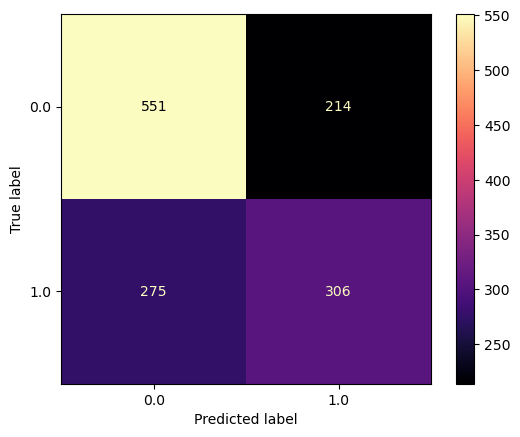

In [20]:
# Install necessary packages
#!pip install -q joblib xlrd openpyxl tpot flask gunicorn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from tpot import TPOTClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify

# Load data with openpyxl to handle .xls file warnings more gracefully
try:
    df = pd.read_excel("../data/EARLY.xls")#, engine='openpyxl')  # Try openpyxl to resolve warnings
except Exception as e:
    print("Error loading file:", e)

# Data Preprocessing
missing_thresh = 0.75  # 75% threshold for dropping columns
df = df.dropna(thresh=int(missing_thresh * len(df)), axis=1).dropna()
df = df.drop(["SEQN"], axis=1)

# Ensure EARLY column is processed correctly
df['EARLY'] = df['EARLY'].fillna('Unknown').astype(str)

# Scale features
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(df.drop(columns=['EARLY'])), columns=df.drop(columns=['EARLY']).columns)
df_scaled = pd.concat([scaled_features, df[['EARLY']]], axis=1)

# Drop remaining NaNs if any
df_scaled = df_scaled.dropna()

# Feature Importance Function
def feature_importance(df, target_col, n_sim=100):
    X, y = df.drop(columns=[target_col]), df[target_col]
    features_imp = pd.DataFrame(index=X.columns)  # Set index to feature names

    for i in range(n_sim):
        model = ExtraTreesClassifier(random_state=i)
        model.fit(X, y)
        features_imp[f'Sim_{i}'] = model.feature_importances_

    mutual_info = pd.DataFrame(index=X.columns)  # Set index to feature names
    for i in range(n_sim):
        mi = mutual_info_classif(X, y, random_state=i)
        mutual_info[f'Sim_{i}'] = mi

    # Returning feature names with their average importance scores
    return features_imp.mean(axis=1).sort_values(ascending=False), mutual_info.mean(axis=1).sort_values(ascending=False)

# Calculate Feature Importance
feature_ranks, mi_ranks = feature_importance(df_scaled, 'EARLY')

# Select Top Features for TPOT, Converting Index to Column Names
top_features = list(feature_ranks.head(10).index)
X = df_scaled[top_features]
y = df_scaled['EARLY']

# Model Selection with TPOT
def best_model_selection(X, y):
    ros = RandomOverSampler()
    X_res, y_res = ros.fit_resample(X, y)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    tpot = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
    tpot.fit(X_res, y_res)
    return tpot

# Split Data and Train TPOT Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
tpot_model = best_model_selection(X_train, y_train)
scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit the scaler to your training data

# Save the best model
joblib.dump(tpot_model.fitted_pipeline_, "../model/eo_best_model.joblib")
joblib.dump(scaler, "../model/scaler.joblib")
# Evaluate Model
y_pred = tpot_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non_EARLY', 'EARLY']))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma')
plt.show()

In [12]:
top_features

['RIDAGEYR',
 'RACE',
 'EDUC',
 'COUPLE',
 'TOTAL_ACCULTURATION_SCORE_v2',
 'FAT',
 'POVERTIES',
 'HTN',
 'RIAGENDR',
 'SMOKER']

In [15]:
df[top_features].describe()

,RIDAGEYR,RACE,EDUC,COUPLE,TOTAL_ACCULTURATION_SCORE_v2,FAT,POVERTIES,HTN,RIAGENDR,SMOKER
count,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000,6090.000000
mean,63.711330,2.113629,2.141379,2.290312,1.960427,2.458456,0.203612,0.807389,1.450246,0.194089
std,11.633313,1.054078,0.855390,0.916871,0.708842,0.707047,0.402717,0.394382,0.497559,0.395530
min,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000
50%,65.000000,2.000000,2.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000
75%,72.000000,3.000000,3.000000,3.000000,2.000000,3.000000,0.000000,1.000000,2.000000,0.000000
max,85.000000,4.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000


In [14]:
df_scaled[top_features].describe()

,RIDAGEYR,RACE,EDUC,COUPLE,TOTAL_ACCULTURATION_SCORE_v2,FAT,POVERTIES,HTN,RIAGENDR,SMOKER
count,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000
mean,0.669649,0.377099,0.565426,0.642332,0.479938,0.729492,0.214891,0.809630,0.447615,0.201070
std,0.177075,0.349751,0.428902,0.459235,0.356871,0.353510,0.410792,0.392637,0.497304,0.400845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.569231,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000
50%,0.676923,0.333333,0.500000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.800000,0.666667,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
